<h1>Email recipient recommendation</h1>

<i>Thomas Boudou, Guillaume Richard, Antoine Simoulin</i>

<p style="text-align: justify">It was shown that at work, employees frequently forget to include one or more recipient(s) before sending a message. Conversely, it is common that some recipients of a given message were actually not intended to receive the message. To increase productivity and prevent information leakage, the needs for effective <b>email recipient recommendation</b> systems are thus pressing.

In this challenge, you are asked to develop such a system, which, given the content and the date of a message, recommends a list of <b>10 recipients ranked by decreasing order of relevance</b>.</p>

<h2>Requirements</h2>

In [1]:
%matplotlib inline
import random
import operator
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

<h2>Load data</h2>

In [2]:
# load some of the files
path_to_data = 'data/'
training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0, encoding='utf-8')
training_info = pd.read_csv(path_to_data + 'training_info.csv', sep=',', header=0, encoding='utf-8')#, index_col = ['mid'])
test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0, encoding='utf-8')
test_info = pd.read_csv(path_to_data + 'test_info.csv', sep=',', header=0, encoding='utf-8')#, index_col = ['mid'])

<h2>Data overview</h2>

In [3]:
print(training.shape)
print(training_info.shape)
print(test.shape)
print(test_info.shape)

(125, 2)
(43613, 4)
(125, 2)
(2362, 3)


In [4]:
training.head()
# for each of the 125 senders ('sender') in the training set, contains a list of message IDs ('mids')

,sender,mids
0,karen.buckley@enron.com,158713 158697 200301 158679 278595 298162 2002...
1,amr.ibrahim@enron.com,215241 3437 215640 3506 191790 3517 3520 3562 ...
2,andrea.ring@enron.com,270705 270706 270707 270708 270709 270710 2707...
3,sylvia.hu@enron.com,111444 111422 183084 111412 111347 110883 1105...
4,phillip.platter@enron.com,327074 327384 327385 264443 274124 274125 2741...


In [5]:
df_ar = np.empty((training_info.shape[0],2), dtype=object)
training_arr = training.values
i = 0
k = 0

while i < training_info.shape[0]:
    for mid in training_arr[k,1].split():
        df_ar[i] = [training_arr[k,0],int(mid)]
        i+=1
    k+=1
    
df = pd.DataFrame(df_ar, columns=['sender','mid'])
df.head()

,sender,mid
0,karen.buckley@enron.com,158713
1,karen.buckley@enron.com,158697
2,karen.buckley@enron.com,200301
3,karen.buckley@enron.com,158679
4,karen.buckley@enron.com,278595


In [6]:
training_info = training_info.merge(df, on='mid')

In [7]:
training_info.head()
# each row contains the ID ('mid'), date, body, and recipients of an email from the training set. 

,mid,date,body,recipients,sender
0,60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...,christian.yoder@enron.com
1,66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...,heather.dunton@enron.com
2,74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...,janel.guerrero@enron.com
3,80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com,tim.belden@enron.com
4,83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...,christian.yoder@enron.com


In [8]:
test_info.head()

,mid,date,body
0,1577,2001-11-19 06:59:51,Note: Stocks of heating oil are very high for...
1,1750,2002-03-05 08:46:57,"Kevin Hyatt and I are going for ""sghetti"" at S..."
2,1916,2002-02-13 14:17:39,This was forwarded to me and it is funny. - Wi...
3,2094,2002-01-22 11:33:56,I will be in to and happy to assist too. I ma...
4,2205,2002-01-11 07:12:19,Thanks. I needed a morning chuckle.


In [9]:
test.head()

,sender,mids
0,karen.buckley@enron.com,298389 332383 298390 284071 366982 81773 81791...
1,amr.ibrahim@enron.com,48260 48465 50344 48268 50330 48237 189979 189...
2,andrea.ring@enron.com,366364 271168 271172 271167 271189
3,sylvia.hu@enron.com,134931 134856 233549 233517 134895 233584 3736...
4,phillip.platter@enron.com,274220 274225 274215 274223 274214 274207 2742...


In [10]:
test.head()
# for each of the 125 senders ('sender') in the test set, contains a list of message IDs ('mids'). 
# For each of these messages, the recipients are to be predicted

,sender,mids
0,karen.buckley@enron.com,298389 332383 298390 284071 366982 81773 81791...
1,amr.ibrahim@enron.com,48260 48465 50344 48268 50330 48237 189979 189...
2,andrea.ring@enron.com,366364 271168 271172 271167 271189
3,sylvia.hu@enron.com,134931 134856 233549 233517 134895 233584 3736...
4,phillip.platter@enron.com,274220 274225 274215 274223 274214 274207 2742...


In [11]:
test_info.head()
# test_info : each row contains the ID ('mid'), date, and body of an email from the test set. 

,mid,date,body
0,1577,2001-11-19 06:59:51,Note: Stocks of heating oil are very high for...
1,1750,2002-03-05 08:46:57,"Kevin Hyatt and I are going for ""sghetti"" at S..."
2,1916,2002-02-13 14:17:39,This was forwarded to me and it is funny. - Wi...
3,2094,2002-01-22 11:33:56,I will be in to and happy to assist too. I ma...
4,2205,2002-01-11 07:12:19,Thanks. I needed a morning chuckle.


In [12]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][0].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][0])

--------------- dest ---------------
robert.badeer@enron.com
murray.o
neil@enron.com
tim.belden@enron.com
elizabeth.sager@enron.com
carla.hoffman@enron.com
jeff.richter@enron.com
chris.stokley@enron.com
valarie.sabo@enron.com
------------------------------------

Legal has been assessing the risks of doing block forward trades as financial and for now, subject to future changes that may be required  as discussions with the CAPX legal experts continue,  we can state the basic rules as follows:It is okay to do up to 50% of  our Block Forward business as financial.It is very important to monitor this 50% level very closely and we should not exceed it. We should not rely on the PX to tell us what the level is. We should confirm it ourselves.  A skeptical regulator, looking at PX records should never be able to see that we ever did more than half our block forward business as financial.  One of the legal rules that we must comply with in this area is that there must be a bona fide commercia

In [13]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][32774].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][32774])

--------------- dest ---------------
gbsonnta@utmb.edu
michael.walters@enron.com
jody.crook@enron.com
mjillard@beaconelectric.com
david.baumbach@enron.com
rachel.m.bonilla@ac.com
bryan.hull@enron.com
todagost@utmb.edu
scott.crowell@us.oracle.com
o
neal.winfree@enron.com
jimmy.simien@enron.com
kyle.lilly@enron.com
kevin.bosse@enron.com
eric.bass@enron.com
cbpels@lyondell.com
james.love@msl.redstone.army.mil
------------------------------------

---------------------- Forwarded by Phillip M Love/HOU/ECT on 06/30/2000 07:33 AM ---------------------------Shane.Dobbs@fctg.com on 06/30/2000 07:17:07 AMTo: bigb@sonet.net, plove@enron.com, jmjaked@mindspring.com, dobbsmw@auburn.edu, dobbswn@auburn.edu, beenemm@auburn.educc:  Subject: FW: Rocker- Here this time-----Original Message----- From: Stevenson_Scott Sent: Wednesday, June 28, 2000 9:52 AM To: BIFP TRADERS Subject: FW: Rocker- Here this time > Subject: Rocker > > > > > > > > > The Top 15 Signs John Rocker Is Your Stockbroker > > > > > > 

In [14]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][18057].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][18057])

--------------- dest ---------------
melissa.murphy@enron.com
------------------------------------

Melissa:We agreed to the form of confirm with ConEd last night.  Michael Forte was to send the redraft to Michael Brown.  I haven t seen it yet.  Sounds like there will be a plain vanilla swap also, which should look like (format) the one we did in January.Sara ShackletonEnron North America Corp.1400 Smith Street, EB 3801aHouston, Texas  77002713-853-5620 (phone)713-646-3490 (fax)sara.shackleton@enron.com


In [54]:
# example mail
n = int(random.random()*training_info.shape[0])
print('mail n°%i\n'%n)
print('--------------- dest ---------------')
for dest in training_info['recipients'][n].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][n])

mail n°37595

--------------- dest ---------------
jim.homco@enron.com
------------------------------------

This is what I see so far for Ogy for May.  We need to buy the imbalance back that was created on the 3rd but we can chat later.


<h2>Features exctraction and definition</h2>

In [16]:
# nltk.download()

In [31]:
import nltk
import string

from collections import Counter

def get_tokens(text):
    # removre capitals letters.
    lowers = text.lower()
    # remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(no_punctuation)
    return tokens

tokens = get_tokens(training_info.body[32774])
count = Counter(tokens)
print(count.most_common(100))

[('you', 10), ('to', 9), ('in', 8), ('your', 7), ('the', 7), ('is', 4), ('rocker', 4), ('he', 4), ('a', 4), ('of', 3), ('money', 3), ('white', 3), ('all', 3), ('and', 3), ('subject', 3), ('here', 2), ('up', 2), ('term', 2), ('on', 2), ('am', 2), ('15', 2), ('fw', 2), ('only', 2), ('this', 2), ('that', 2), ('now', 2), ('stocks', 2), ('him', 2), ('when', 2), ('06302000', 2), ('his', 2), ('invest', 1), ('nest', 1), ('phillip', 1), ('stevensonscott', 1), ('covering', 1), ('7', 1), ('one', 1), ('rally', 1), ('nasdaq', 1), ('greenwich', 1), ('tell', 1), ('mitsubishi', 1), ('slaps', 1), ('commemorative', 1), ('prefers', 1), ('decker', 1), ('since', 1), ('400000', 1), ('plates', 1), ('message', 1), ('6', 1), ('not', 1), ('short', 1), ('amto', 1), ('bigbsonetnet', 1), ('cracker', 1), ('stockbroker', 1), ('elvis', 1), ('aren', 1), ('possum', 1), ('mint', 1), ('profitable', 1), ('futures', 1), ('2000', 1), ('misreading', 1), ('dumps', 1), ('thinks', 1), ('bifp', 1), ('ass', 1), ('11', 1), ('retir

In [32]:
# nltk.download("stopwords")

In [33]:
from nltk.corpus import stopwords
# These are uninformative, so let's remove the stop words.
tokens = get_tokens(training_info.body[32774])
filtered = [w for w in tokens if not w in stopwords.words('english')]
count = Counter(filtered)
print(count.most_common(100))

[('rocker', 4), ('money', 3), ('subject', 3), ('white', 3), ('stocks', 2), ('term', 2), ('06302000', 2), ('15', 2), ('fw', 2), ('diversify', 1), ('hamburgers', 1), ('invest', 1), ('nest', 1), ('phillip', 1), ('stevensonscott', 1), ('traders', 1), ('bread', 1), ('7', 1), ('14', 1), ('beenemmauburneducc', 1), ('lovehouect', 1), ('rally', 1), ('picks', 1), ('8', 1), ('5', 1), ('nasdaq', 1), ('misreading', 1), ('sounds', 1), ('tell', 1), ('black', 1), ('forwarded', 1), ('retirement', 1), ('entirely', 1), ('shares', 1), ('slaps', 1), ('catfish', 1), ('threatening', 1), ('refers', 1), ('decker', 1), ('4', 1), ('even', 1), ('952', 1), ('400000', 1), ('ends', 1), ('message', 1), ('6', 1), ('wednesday', 1), ('punch', 1), ('short', 1), ('yahoo', 1), ('time', 1), ('bigbsonetnet', 1), ('castle', 1), ('dipshit', 1), ('owner', 1), ('suddenly', 1), ('elvis', 1), ('possum', 1), ('invested', 1), ('cracker', 1), ('mint', 1), ('amto', 1), ('stockbroker', 1), ('keeps', 1), ('profitable', 1), ('top', 1), (

In [34]:
from nltk.stem.porter import *
# We can also do stemming using NLTK using a Porter Stemmer.
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(filtered, stemmer)
count = Counter(stemmed)
print(count.most_common(100))

[('rocker', 4), ('money', 3), ('subject', 3), ('white', 3), ('stock', 3), ('invest', 2), ('term', 2), ('fw', 2), ('threaten', 2), ('06302000', 2), ('15', 2), ('short', 2), ('chines', 1), ('nest', 1), ('call', 1), ('phillip', 1), ('stevensonscott', 1), ('broker', 1), ('end', 1), ('7', 1), ('rock', 1), ('14', 1), ('beenemmauburneducc', 1), ('11', 1), ('8', 1), ('sign', 1), ('5', 1), ('nasdaq', 1), ('greenwich', 1), ('timeorigin', 1), ('black', 1), ('messag', 1), ('misread', 1), ('catfish', 1), ('convinc', 1), ('line', 1), ('show', 1), ('pan', 1), ('decker', 1), ('4', 1), ('even', 1), ('952', 1), ('400000', 1), ('prefer', 1), ('pick', 1), ('13', 1), ('6', 1), ('foxworthi', 1), ('punch', 1), ('wednesday', 1), ('yahoo', 1), ('time', 1), ('bigbsonetnet', 1), ('dipshit', 1), ('owner', 1), ('sound', 1), ('bread', 1), ('possum', 1), ('plate', 1), ('tri', 1), ('put', 1), ('mint', 1), ('amto', 1), ('forward', 1), ('top', 1), ('castl', 1), ('street', 1), ('egg', 1), ('proud', 1), ('suddenli', 1), 

In [36]:
# With our cleaned up text, we can now use it for searching, 
# document similarity, or other tasks (clustering, classification) 
# that we'll learn about later on. Unfortunately, 
# calculating tf-idf is not available in NLTK so we'll use another data analysis library, 
# scikit-learn. Scikit-learn has a built in Tf-Idf implementation 
# but we can use NLTK's tokenizer and stemmer to preprocess the text.

import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

for i in range(training_info.shape[0]):
    text = training_info.body[i]
    lowers = text.lower()
    no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
    token_dict[i] = no_punctuation
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
X_train_tfidf = tfidf.fit_transform(token_dict.values())

In [39]:
feature_names = tfidf.get_feature_names()
a = 0
for col in X_train_tfidf.nonzero()[1][:10]:
    print('%20s - %.3f' %(feature_names[col],X_train_tfidf[a, col])) # tf-idf for each term found in document a

               legal - 0.159
                  ha - 0.037
              assess - 0.077
                risk - 0.113
               block - 0.240
             forward - 0.099
               trade - 0.091
             financi - 0.281
             subject - 0.030
               futur - 0.060


<h2>Structures creation and definition</h2>

In [55]:
# convert training set to dictionary
# each sender is described with a key and is associated a list of message IDs (mids)
emails_ids_per_sender = {}
for index, series in training.iterrows():
    row = series.tolist()
    sender = row[0]
    ids = row[1:][0].split(' ')
    emails_ids_per_sender[sender] = ids

# save all unique sender names
all_senders = emails_ids_per_sender.keys()

# create address book with frequency information for each user
address_books = {}
i = 0

for sender, ids in emails_ids_per_sender.items():
    recs_temp = []
    for my_id in ids:
        recipients = training_info[training_info['mid']==int(my_id)]['recipients'].tolist()
        recipients = recipients[0].split(' ')
        # keep only legitimate email addresses
        recipients = [rec for rec in recipients if '@' in rec]
        recs_temp.append(recipients)
    # flatten    
    recs_temp = [elt for sublist in recs_temp for elt in sublist]
    # compute recipient counts
    rec_occ = dict(Counter(recs_temp))
    # order by frequency
    sorted_rec_occ = sorted(rec_occ.items(), key=operator.itemgetter(1), reverse = True)
    # save
    address_books[sender] = sorted_rec_occ

In [88]:
print(address_books[list(address_books.keys())[0]])

[('amanda.huble@enron.com', 40), ('michelle.nelson@enron.com', 23), ('8774820772@pagenetmessage.net', 4), ('capstone@texas.net', 4), ('john.arnold@enron.com', 4), ('kim.ward@enron.com', 2), ('john.griffith@enron.com', 2), ('larry.may@enron.com', 2), ('sandra.f.brawner@enron.com', 1), ('laura.vuittonet@enron.com', 1), ('amanda.rybarski@enron.com', 1)]


In [148]:
nb_sender = {}
for sender in list(address_books.keys()):
    expl = [x for x in address_books[sender]] 
    y_val = [x[1] for x in expl]
    nb_sender[sender]= sum(y_val)

In [149]:
# average number of recipients per sender
print(sum(nb_sender[d] for d in nb_sender) / len(nb_sender))

2159.84


In [180]:
top_sender = [sender for sender in nb_sender if nb_sender[sender]>10000]
for sender in top_sender:
    print(sender, nb_sender[sender], sender in test.sender.values)

ginger.dernehl@enron.com 27594 True
l..denton@enron.com 16224 True
cheryl.johnson@enron.com 27371 True
lorna.brennan@enron.com 20796 True


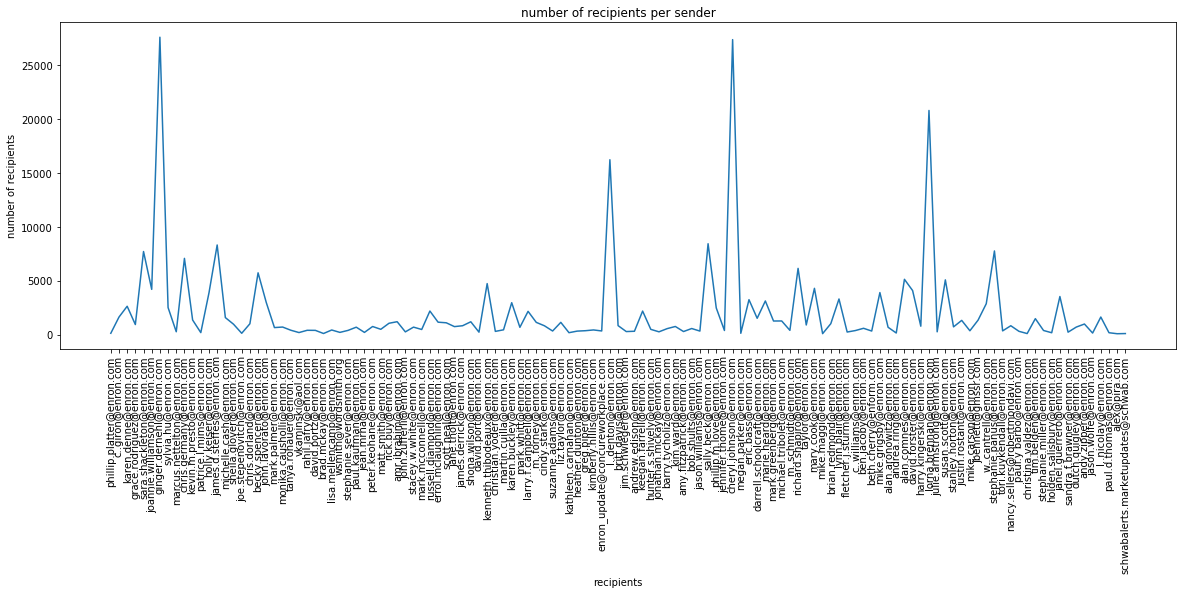

In [182]:
# distribution of #recipients per sender
fig = plt.figure(figsize=[20,6])
plt.plot([nb_sender[d] for d in nb_sender])
plt.xticks(range(len(nb_sender)), [d for d in nb_sender], rotation='vertical')
plt.ylabel('number of recipients')
plt.xlabel('recipients')
plt.title('number of recipients per sender')
plt.show()

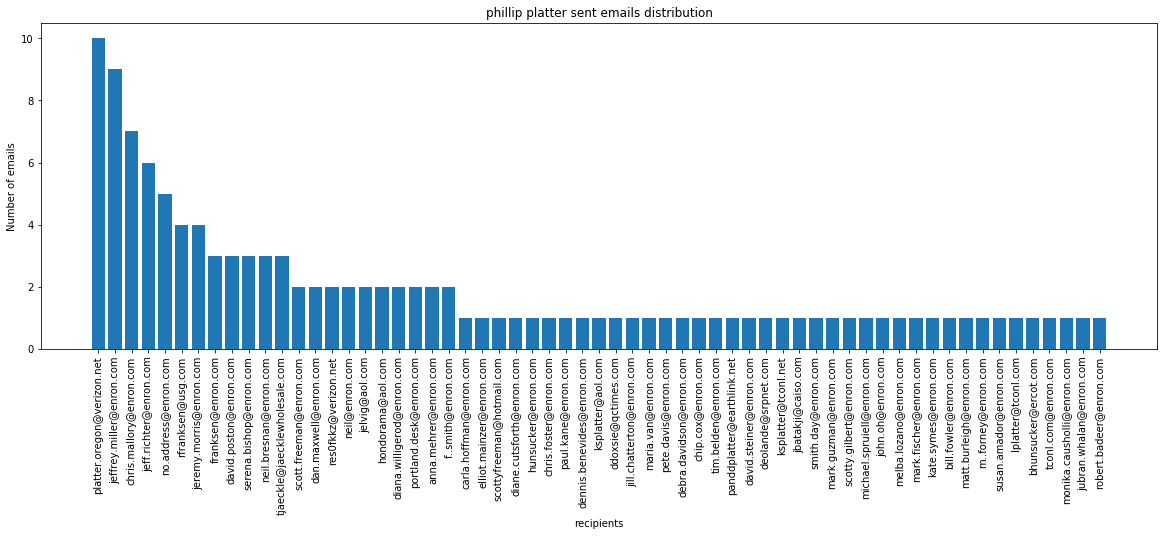

In [166]:
expl = [x for x in address_books['phillip.platter@enron.com']]
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients')
plt.title('phillip platter sent emails distribution')
plt.show()

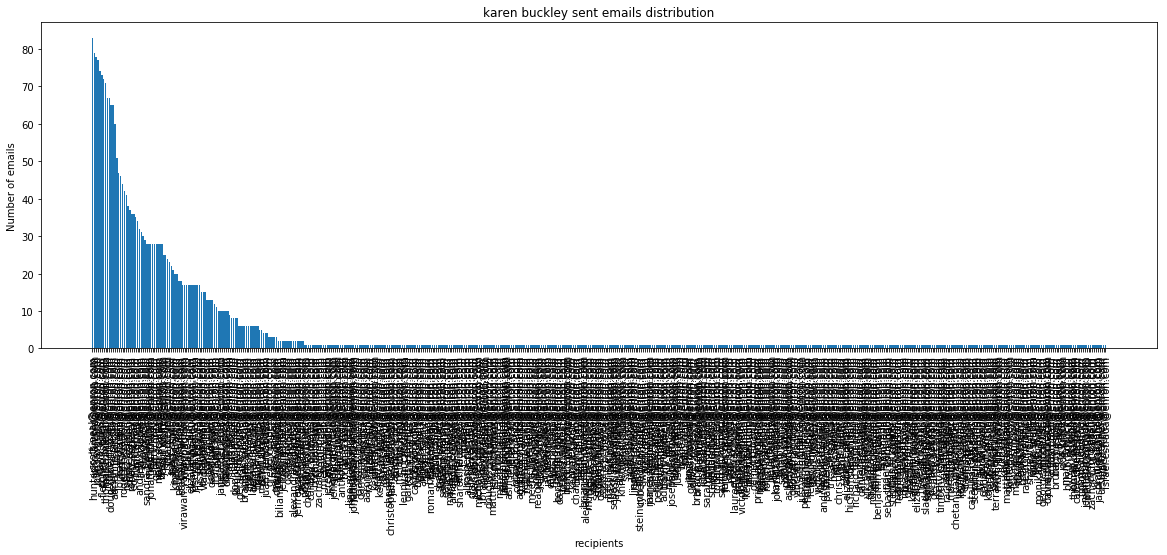

In [144]:
expl = [x for x in address_books['karen.buckley@enron.com']] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients')
plt.title('karen buckley sent emails distribution')
plt.show()

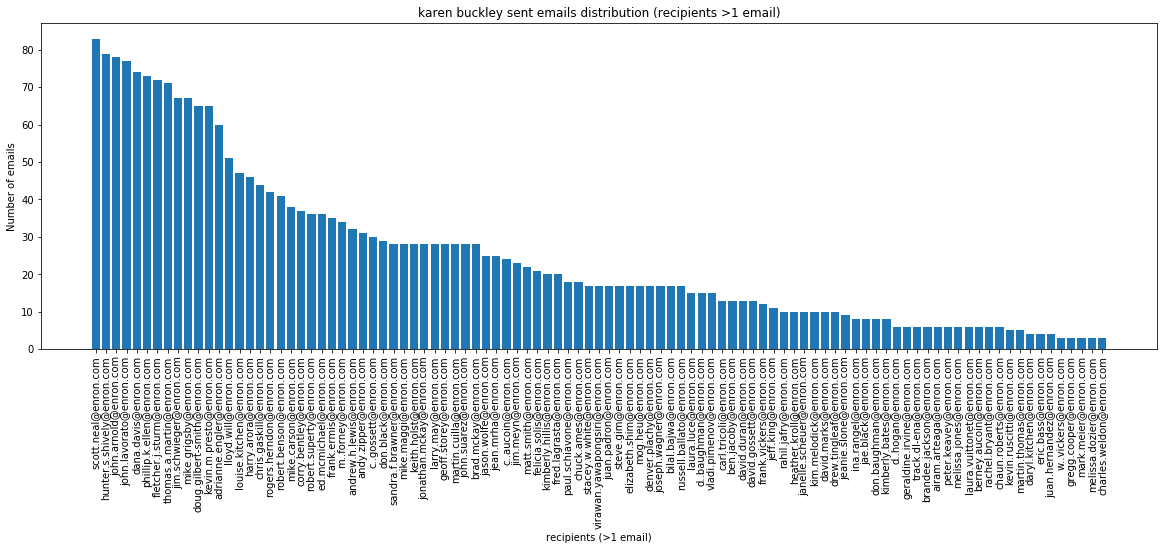

In [145]:
expl = [x for x in address_books['karen.buckley@enron.com'] if x[1]>2] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients (>1 email)')
plt.title('karen buckley sent emails distribution (recipients >1 email)')
plt.show()

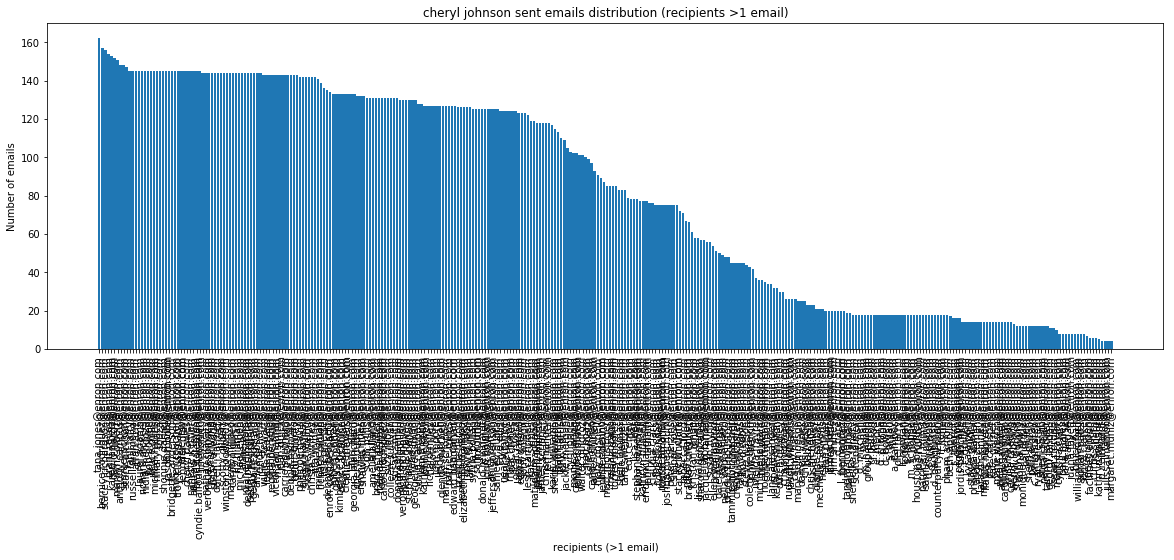

In [165]:
expl = [x for x in address_books['cheryl.johnson@enron.com'] if x[1]>2] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients (>1 email)')
plt.title('cheryl johnson sent emails distribution (recipients >1 email)')
plt.show()


In [52]:
y_train = training_info.recipients.str.split()
y_train = [x for x in y_train]
print(y_train[0])

['robert.badeer@enron.com', 'murray.o', 'neil@enron.com', 'tim.belden@enron.com', 'elizabeth.sager@enron.com', 'carla.hoffman@enron.com', 'jeff.richter@enron.com', 'chris.stokley@enron.com', 'valarie.sabo@enron.com']


In [186]:
print(X_train_tfidf.shape)

(43613, 286157)


In [ ]:
y_train_tfidf = np.zeros((X_train_tfidf.shape[0],len(all_senders)))

<h2>Classifier definition</h2>

In [184]:

from sklearn.naive_bayes import MultinomialNB
clf ={}
i = 0
y_train_tfidf = np.zeros((X_train_tfidf.shape[0],len(all_senders)+1))
for sender in all_senders:
    for j in range(X_train_tfidf.shape[0]):
        if sender in y_train[j]:
            y_train_tfidf [j,i]= 1
    i+=1
    clf[sender] = MultinomialNB().fit(X_train_tfidf, y_train_tfidf[:,i])

In [199]:
print(all_senders)

dict_keys(['mike.maggi@enron.com', 'paul.d.thomas@enron.com', 'wsmith@wordsmith.org', 'michael.tribolet@enron.com', 'holden.salisbury@enron.com', 'julie.armstrong@enron.com', 'stephanie.sever@enron.com', 'justin.rostant@enron.com', 'matt.smith@enron.com', 'tim.belden@enron.com', 'brian.redmond@enron.com', 'sylvia.hu@enron.com', 'mary.cook@enron.com', 'amr.ibrahim@enron.com', 'andrew.edison@enron.com', 'shona.wilson@enron.com', 'fletcher.j.sturm@enron.com', 'jim.schwieger@enron.com', 'cindy.stark@enron.com', 'l..denton@enron.com', 'mark.greenberg@enron.com', 'stephanie.miller@enron.com', 'marcus.nettelton@enron.com', 'christian.yoder@enron.com', 'mark.mcconnell@enron.com', 'james.d.steffes@enron.com', 'c..williams@enron.com', 'peter.keohane@enron.com', 'sheila.glover@enron.com', 'hunter.s.shively@enron.com', 'karen.denne@enron.com', 'jonathan.mckay@enron.com', 'jennifer.thome@enron.com', 'martin.cuilla@enron.com', 'barry.tycholiz@enron.com', 'becky.spencer@enron.com', 'holly.keiser@enro

In [187]:
str = 'this sentence has unseen text such as computer but also king lord juliet'
response = tfidf.transform([str])
print(response)

  (0, 270638)	0.452998018322
  (0, 260948)	0.0906755961607
  (0, 257028)	0.318460114908
  (0, 239600)	0.331494562371
  (0, 179325)	0.387078105027
  (0, 170597)	0.31621849887
  (0, 168013)	0.49141065427
  (0, 147796)	0.130308501836
  (0, 102946)	0.258798969837


In [200]:
token_dict_test = {}
for i in range(test_info.shape[0]):
    text = test_info.body[i]
    lowers = text.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict_test[i] = no_punctuation

X_test_tfidf = tfidf.transform(token_dict_test.values())
y_pred = clf['mike.maggi@enron.com'].predict(X_test_tfidf)

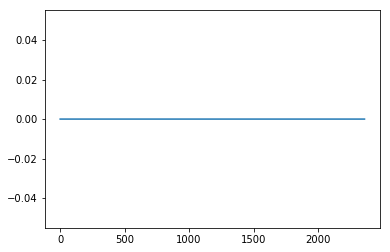

In [198]:
plt.plot(y_pred)
plt.show()

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

text_clf = Pipeline([('pca', PCA(n_components=40)),
                     ('clf', MultinomialNB()),
])

text_clf.fit(X_train_tfidf, y_train)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

<h2>Submission file</h2>

In [35]:
 # save all unique recipient names    
all_recs = list(set([elt[0] for sublist in address_books.values() for elt in sublist]))

# save all unique user names 
all_users = []
all_users.extend(all_senders)
all_users.extend(all_recs)
all_users = list(set(all_users))

# baselines                        

# will contain email ids, predictions for random baseline, and predictions for frequency baseline
predictions_per_sender = {}

# number of recipients to predict
k = 10

for index, row in test.iterrows():
    name_ids = row.tolist()
    sender = name_ids[0]
    # get IDs of the emails for which recipient prediction is needed
    ids_predict = name_ids[1].split(' ')
    ids_predict = [int(my_id) for my_id in ids_predict]
    random_preds = []
    freq_preds = []
    # select k most frequent recipients for the user
    k_most = [elt[0] for elt in address_books[sender][:k]]
    for id_predict in ids_predict:
        # select k users at random
        random_preds.append(random.sample(all_users, k))
        # for the frequency baseline, the predictions are always the same
        freq_preds.append(k_most)
    predictions_per_sender[sender] = [ids_predict,random_preds,freq_preds]	

# write predictions in proper format for Kaggle                         
path_to_results = 'pred/'

with open(path_to_results + 'predictions_random.txt', 'w') as my_file:
    my_file.write('mid,recipients' + '\n')
    for sender, preds in predictions_per_sender.items():
        ids = preds[0]
        random_preds = preds[1]
        for index, my_preds in enumerate(random_preds):
            my_file.write(str(ids[index]) + ',' + ' '.join(my_preds) + '\n')

with open(path_to_results + 'predictions_frequency.txt', 'w') as my_file:
    my_file.write('mid,recipients' + '\n')
    for sender, preds in predictions_per_sender.items():
        ids = preds[0]
        freq_preds = preds[2]
        for index, my_preds in enumerate(freq_preds):
            my_file.write(str(ids[index]) + ',' + ' '.join(my_preds) + '\n')